In [1]:

import json
import pandas as pd
import numpy as np
from toolz import memoize
import datetime
import math

from tqdm import tqdm
from src.utils.mouselab_jas import MouselabJas
from src.utils.distributions import Normal, expectation
from src.utils.env_creation import create_tree, create_init
from src.utils.env_export import create_json
from src.utils.data_classes import MouselabConfig, Action
from simulation import run_simulation
from src.policy.jas_voc_policy import JAS_voc_policy
from src.policy.jas_policy import RandomPolicy, ExhaustivePolicy, RandomNPolicy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from src.utils.utils import sigma_to_tau
import numpy as np
from src.utils.env_export import format_payoff
from src.utils.khalili_env import get_env


sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.5)
sns.set_theme()

%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv("./data/experiment_results/exp_5.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'Participant', 'Condition', 'TrialId', 'Score',
       'ExpectedScore', 'NumClicks', 'Actions', 'Selection', 'Seed',
       'ClickAgreement'],
      dtype='object')

In [5]:
df.groupby(["Condition"]).count()["Participant"] / 10

Condition
0    101.0
1     98.0
2     99.0
Name: Participant, dtype: float64

In [6]:
df.groupby("Condition").agg(["mean", "std"]).round(4)[["ExpectedScore", "ClickAgreement", "NumClicks"]]

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_4256\2390542040.py:1: FutureWarning: ['TrialId', 'Actions'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("Condition").agg(["mean", "std"]).round(4)[["ExpectedScore", "ClickAgreement", "NumClicks"]]


ExpectedScore         ClickAgreement         NumClicks        
                   mean     std           mean     std      mean     std
Condition                                                               
0                3.5176  0.1973         0.2521  0.2777    3.5950  1.8660
1                3.5858  0.1903         0.4271  0.3211    4.0306  1.4204
2                3.5265  0.1922         0.2664  0.2547    3.8646  1.8177

<AxesSubplot: xlabel='Condition', ylabel='ClickAgreement'>

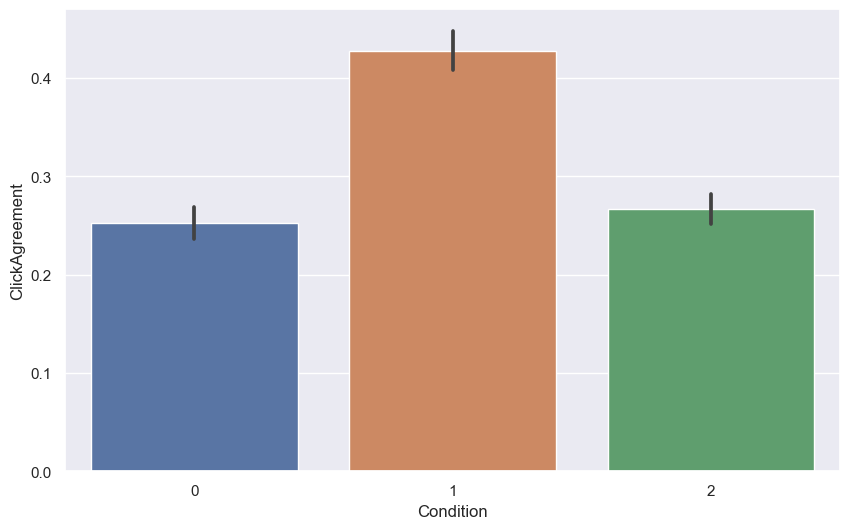

In [7]:
sns.barplot(df, y="ClickAgreement", x="Condition")

(3.3, 3.7)

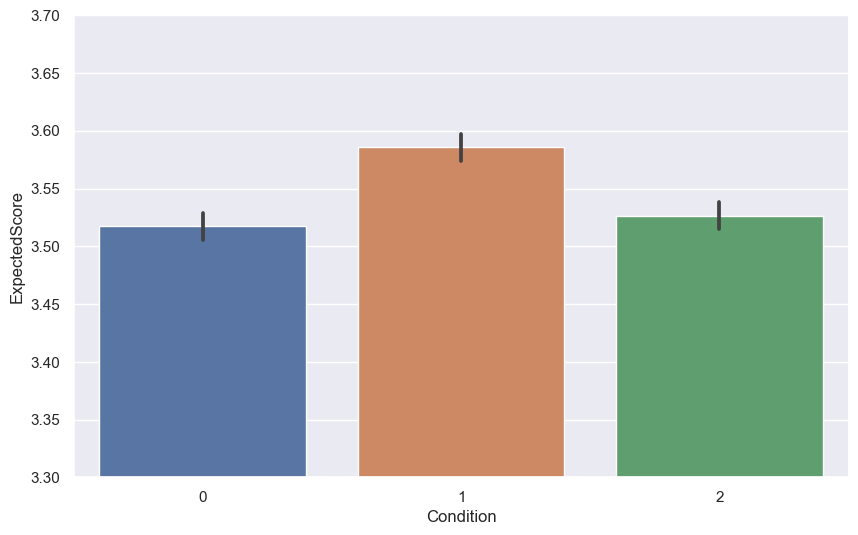

In [8]:
g = sns.barplot(df, y="ExpectedScore", x="Condition")
g.set_ylim(3.3, 3.7)

In [9]:
baseline_df = pd.read_csv("./data/experiment_results/random_baseline.csv")
baseline_df = baseline_df.astype({'seed':'int'}).set_index("seed")
baseline_df

,Unnamed: 0,reward,actions,runtime,true_reward,expected_reward
seed,,,,,,
12,0,3.509576,4.9222,0.001303,3.894847,3.509576
13,1,3.527022,4.9086,0.001295,3.921715,3.527022
14,2,3.498825,4.9246,0.001308,3.610339,3.498825
15,3,3.510792,4.9127,0.001473,3.574298,3.510792
16,4,3.499757,4.9218,0.001420,3.222883,3.499757
17,5,3.572623,4.9146,0.001420,4.224300,3.572623
18,6,3.544299,4.9184,0.001367,3.676118,3.544299
19,7,3.537451,4.9148,0.001414,3.952736,3.537451
20,8,3.517815,4.9179,0.001444,3.435968,3.517815


mean    0.106879
std     1.000000
Name: NormalizedReward, dtype: float64


Text(0.5, 1.0, '(participant_scores - mean(baseline_scores)) / std(participant_scores)')

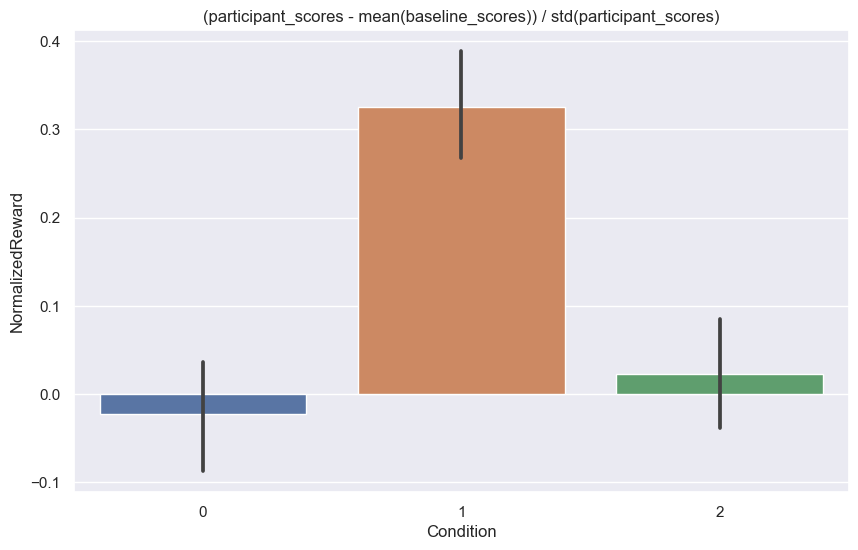

In [10]:
mean = baseline_df["reward"].mean()
std = df["ExpectedScore"].std()
df["NormalizedReward"] = (df["ExpectedScore"] - mean) / std
print(df["NormalizedReward"].agg(["mean", "std"]))
g = sns.barplot(df, y="NormalizedReward", x="Condition")
g.set_title("(participant_scores - mean(baseline_scores)) / std(participant_scores)")

In [13]:
df[["Condition", "NormalizedReward", "ClickAgreement"]].groupby("Condition").agg(["mean", "std"]).round(4)

NormalizedReward         ClickAgreement        
                      mean     std           mean     std
Condition                                                
0                  -0.0227  1.0087         0.2521  0.2777
1                   0.3256  0.9727         0.4271  0.3211
2                   0.0225  0.9827         0.2664  0.2547

In [15]:
def ci(column):
    stats = df[["Condition", column]].groupby("Condition").agg(["mean", "count", "std"])
    ci95 = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95.append(1.96*s/math.sqrt(c))
    
    stats['ci95'] = ci95
    return stats.round(4)

ci("NormalizedReward")

NormalizedReward                  ci95
                      mean count     std        
Condition                                       
0                  -0.0227  1010  1.0087  0.0622
1                   0.3256   980  0.9727  0.0609
2                   0.0225   990  0.9827  0.0612

In [16]:
ci("ClickAgreement")

ClickAgreement                  ci95
                    mean count     std        
Condition                                     
0                 0.2521  1010  0.2777  0.0171
1                 0.4271   980  0.3211  0.0201
2                 0.2664   990  0.2547  0.0159

In [17]:
def cohend(d1, d2):
    # https://machinelearningmastery.com/effect-size-measures-in-python/
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

def effect_size(column):
    no_tutor = df[df["Condition"]==0][column]
    choice_tutor = df[df["Condition"]==1][column]
    dummy_tutor = df[df["Condition"]==2][column]

    print("Cohen's d between choice tutor and no tutor:", cohend(choice_tutor, no_tutor))
    print("Cohen's d between choice tutor and dummy tutor:", cohend(choice_tutor, dummy_tutor))
    print("Cohen's d between no tutor and dummy tutor:", cohend(no_tutor, dummy_tutor))

effect_size("ExpectedScore")

Cohen's d between choice tutor and no tutor: 0.351383844014203
Cohen's d between choice tutor and dummy tutor: 0.3099789489468115
Cohen's d between no tutor and dummy tutor: -0.04536646854659123


In [18]:
effect_size("ClickAgreement")

Cohen's d between choice tutor and no tutor: 0.5838100844483174
Cohen's d between choice tutor and dummy tutor: 0.5547391888972275
Cohen's d between no tutor and dummy tutor: -0.0539016017253772


In [19]:
# MGPS reward
from simulation import run_simulation
env, config = get_env(5, term_belief=False)
voc_policy = JAS_voc_policy(discrete_observations=True, cost_weight=0.5798921379230035)

mgps_res, mgps_actions = run_simulation(env, voc_policy, n=10, start_seed=12)
mgps_res


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


,reward,actions,seed,runtime,true_reward,expected_reward
0,4.330025,5,12,1.109375,4.330025,3.716219
1,4.498135,2,13,0.671875,4.498135,3.823586
2,4.102660,5,14,1.109375,4.102660,3.716219
3,4.280379,3,15,0.921875,4.280379,3.821586
4,3.518098,5,16,1.062500,3.518098,3.499094
5,5.007722,5,17,1.046875,5.007722,3.817586
6,3.775033,3,18,0.843750,3.775033,3.821586
7,4.179104,4,19,1.031250,4.179104,3.819586
8,3.922634,2,20,0.640625,3.922634,3.823586
9,3.673830,5,21,1.109375,3.673830,3.658340


In [20]:
mean = baseline_df["reward"].mean()
std = df["ExpectedScore"].std()
mgps_res["NormalizedReward"] = (mgps_res["expected_reward"] - mean) / std
print(mgps_res["NormalizedReward"].agg(["mean", "std"]))
print(1.96*mgps_res["NormalizedReward"].std()/math.sqrt(mgps_res["NormalizedReward"].count()))

mean    1.174134
std     0.549778
Name: NormalizedReward, dtype: float64
0.3407559011074728


In [21]:
mgps_res

,reward,actions,seed,runtime,true_reward,expected_reward,NormalizedReward
0,4.330025,5,12,1.109375,4.330025,3.716219,0.992555
1,4.498135,2,13,0.671875,4.498135,3.823586,1.541417
2,4.102660,5,14,1.109375,4.102660,3.716219,0.992555
3,4.280379,3,15,0.921875,4.280379,3.821586,1.531193
4,3.518098,5,16,1.062500,3.518098,3.499094,-0.117385
5,5.007722,5,17,1.046875,5.007722,3.817586,1.510745
6,3.775033,3,18,0.843750,3.775033,3.821586,1.531193
7,4.179104,4,19,1.031250,4.179104,3.819586,1.520969
8,3.922634,2,20,0.640625,3.922634,3.823586,1.541417
9,3.673830,5,21,1.109375,3.673830,3.658340,0.696680


In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
mgps_tutor_mean = df[["Participant", "NormalizedReward"]][df["Condition"]==1].groupby("Participant").mean()
print(np.mean(mgps_tutor_mean > 0.9))

NormalizedReward    0.22449
dtype: float64


<AxesSubplot: ylabel='Percent'>

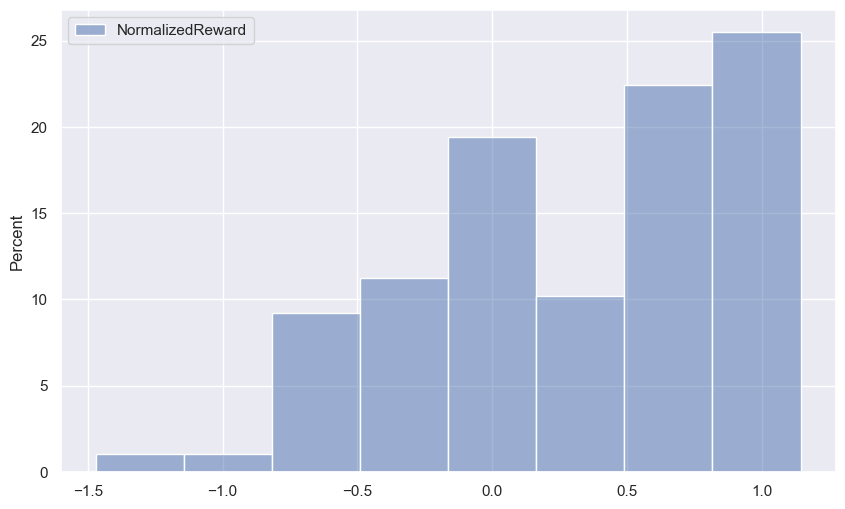

In [34]:
sns.histplot(mgps_tutor_mean, stat="percent")